In [201]:
import yfinance as yf
import pmdarima as pm
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from pmdarima.arima import ndiffs
from pmdarima.arima import auto_arima
from statsmodels.tsa.stattools import adfuller, acf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
from statsmodels.tsa.api import VAR


In [ ]:
# 대차잔고 (O)
# 외국인 투자 (o)
# 나스닥/S%P 500(o)
# 국채3년 (o) -> 신용스프레드의 항목하고 겹치는데..? 
# 신용 스프레드 (o)
# 환율(o)
# 구리(o)

In [5]:
# MacOS - 한글 폰트
from matplotlib import rc
rc('font', family='AppleGothic')
plt.rcParams['axes.unicode_minus'] = False


In [202]:
# 1. 데이터 수집(시가총액 10위)
stocks = ['삼성전자','현대차', 'POSCO', '현대모비스', '한국전력','SK하이닉스', '신한지주', 'LG화학', '삼성생명', 'NAVER']
ticker = ['005930', '005380', '005490', '012330', '015760', '000660', '055550', '051915', '032830', '035420']
st = {}

for i, t in enumerate(ticker):
    symbol = t+'.KS'
    data = yf.download(symbol , '2009-01-01', '2019-12-31')
    st[stocks[i]] = data

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [203]:
var_df = pd.DataFrame()

In [204]:
var_df['삼성전자'] = st['삼성전자']['Adj Close']

In [205]:
# 대차잔고 데이터 수집
df = pd.read_excel('./대차잔고.xlsx', names=['Date', '체결(주수)', '상환(주수)', '잔고', '금액'])
df = df[3:-2].reset_index(drop=True)
df['Date'] = df['Date'].apply(pd.to_datetime)
df.set_index('Date', inplace=True)

var_df['대차잔고'] = df['금액'].str.replace(',', '').astype(float) * 1000000000


/opt/homebrew/lib/python3.11/site-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


In [206]:
var_df['대차잔고']

Date
2009-01-02    1.101600e+13
2009-01-05    1.286200e+13
2009-01-06    1.321200e+13
2009-01-07    1.379100e+13
2009-01-08    1.361200e+13
                  ...     
2019-12-23    6.496400e+13
2019-12-24    6.243100e+13
2019-12-26    6.201000e+13
2019-12-27    6.081100e+13
2019-12-30    6.235200e+13
Name: 대차잔고, Length: 2718, dtype: float64

In [207]:
# 환율 가져오기
import FinanceDataReader as fdr
#원달러환율(USD/KRW)
df = fdr.DataReader('USD/KRW', "2009-01-01", "2019-12-31")
var_df['환율'] = df['Close']

In [208]:
# 구리 데이터 수집
df = fdr.DataReader("HG=F", "2009-01-01", "2019-12-31")
var_df['구리'] = df['Close']
df.head()

,Open,High,Low,Close,Volume
Date,,,,,
2009-01-02,1.3420,1.4420,1.4420,1.4440,258.0
2009-01-05,1.4215,1.4460,1.4145,1.4420,251.0
2009-01-06,1.4835,1.5645,1.4835,1.5660,136.0
2009-01-07,1.5420,1.5450,1.4870,1.4945,226.0
2009-01-08,1.4800,1.4945,1.4400,1.4630,231.0


In [209]:
# 신용스프레드 = 국채3년물 - 회사채3년물bb(-) (일자별로)
df = pd.read_csv('./시장금리(일별)_04175822.csv', names=['국고채(3년)', '회사채(3년, BBB-)'])
df = df[1:]
df.index = pd.to_datetime(df.index)
df = df.astype(float)

df['신용스프레드'] = df['회사채(3년, BBB-)'] - df['국고채(3년)']
var_df['신용스프레드'] = df['신용스프레드']
var_df['국채'] = df['국고채(3년)']
df.head()

,국고채(3년),"회사채(3년, BBB-)",신용스프레드
2009-01-02,3.42,12.04,8.62
2009-01-05,3.35,11.87,8.52
2009-01-06,3.34,11.85,8.51
2009-01-07,3.45,11.90,8.45
2009-01-08,3.26,11.70,8.44


In [210]:
# 나스닥 / S&P 500

df_nas = fdr.DataReader('IXIC', '2009-01-01', '2019-12-31')
df_sp = fdr.DataReader('S&P500', '2009-01-01', '2019-12-31')

var_df['나스닥'] = df_nas['Close']
var_df['S&P500'] = df_sp['Close']
print(df_nas.head())
print(df_sp.head())


                   Open         High          Low        Close      Volume
Date                                                                      
2009-01-02  1578.869995  1636.030029  1571.979980  1632.209961  1438410000
2009-01-05  1621.479980  1640.459961  1604.630005  1628.030029  1816580000
2009-01-06  1642.369995  1665.630005  1636.250000  1652.380005  2137640000
2009-01-07  1621.630005  1625.369995  1588.199951  1599.060059  2020170000
2009-01-08  1590.250000  1617.010010  1584.280029  1617.010010  1968160000
                  Open        High         Low       Close      Volume
Date                                                                  
2009-01-02  902.989990  934.729980  899.349976  931.799988  4048270000
2009-01-05  929.169983  936.630005  919.530029  927.450012  5413910000
2009-01-06  931.169983  943.849976  927.280029  934.700012  5392620000
2009-01-07  927.450012  927.450012  902.369995  906.650024  4704940000
2009-01-08  905.729980  910.000000  896.809998  9

In [211]:
var_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2718 entries, 2009-01-02 to 2019-12-30
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   삼성전자    2718 non-null   float64
 1   대차잔고    2717 non-null   float64
 2   환율      2712 non-null   float64
 3   구리      2633 non-null   float64
 4   신용스프레드  2717 non-null   float64
 5   국채      2717 non-null   float64
 6   나스닥     2636 non-null   float64
 7   S&P500  2636 non-null   float64
dtypes: float64(8)
memory usage: 191.1 KB


In [212]:
df = var_df.copy()

In [213]:
df.isna().sum()

삼성전자       0
대차잔고       1
환율         6
구리        85
신용스프레드     1
국채         1
나스닥       82
S&P500    82
dtype: int64

In [214]:
df = df[1:]

In [215]:
# 결측치 처리 : 전날의 값으로 대체하자!

df = df.fillna(method='ffill')
df

/var/folders/1s/73zrjgnx2w19qtc6h3mxcwxh0000gn/T/ipykernel_16052/868134447.py:3: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')


,삼성전자,대차잔고,환율,구리,신용스프레드,국채,나스닥,S&P500
Date,,,,,,,,
2009-01-05,7283.844727,1.286200e+13,1307.800049,1.4420,8.520,3.350,1628.030029,927.450012
2009-01-06,7620.496582,1.321200e+13,1304.400024,1.5660,8.510,3.340,1652.380005,934.700012
2009-01-07,8018.352051,1.379100e+13,1301.000000,1.4945,8.450,3.450,1599.060059,906.650024
2009-01-08,7773.515625,1.361200e+13,1330.400024,1.4630,8.440,3.260,1617.010010,909.729980
2009-01-09,7543.984863,1.338900e+13,1351.699951,1.5455,8.420,3.480,1571.589966,890.349976
...,...,...,...,...,...,...,...,...
2019-12-23,49987.886719,6.496400e+13,1159.300049,2.8170,6.682,1.380,8945.650391,3224.010010
2019-12-24,49537.539062,6.243100e+13,1161.569946,2.8385,6.687,1.370,8952.879883,3223.379883
2019-12-26,49897.816406,6.201000e+13,1159.750000,2.8645,6.686,1.367,9022.389648,3239.909912


In [216]:
# granger 인과검정 실시
from statsmodels.tsa.stattools import grangercausalitytests

# 1. 정상성 확보
for i in df:
    cnt = ndiffs(df[i].values)
    print(cnt)
    if cnt >= 1:
        df[i] = df[i].diff(cnt).dropna()

1
1
1
1
2
1
1
1


In [217]:
df

,삼성전자,대차잔고,환율,구리,신용스프레드,국채,나스닥,S&P500
Date,,,,,,,,
2009-01-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2009-01-06,336.651855,3.500000e+11,-3.400025,0.1240,NaN,-0.010,24.349976,7.250000
2009-01-07,397.855469,5.790000e+11,-3.400024,-0.0715,-0.070,0.110,-53.319946,-28.049988
2009-01-08,-244.836426,-1.790000e+11,29.400024,-0.0315,-0.070,-0.190,17.949951,3.079956
2009-01-09,-229.530762,-2.230000e+11,21.299927,0.0825,-0.030,0.220,-45.420044,-19.380004
...,...,...,...,...,...,...,...,...
2019-12-23,-450.332031,-1.183000e+12,-1.760010,0.0060,0.004,-0.012,20.690430,2.790039
2019-12-24,-450.347656,-2.533000e+12,2.269897,0.0215,0.009,-0.010,7.229492,-0.630127
2019-12-26,360.277344,-4.210000e+11,-1.819946,0.0260,0.004,-0.003,69.509765,16.530029


In [218]:
df.dropna(inplace=True)

In [220]:
df_pairs = pd.DataFrame(data=np.zeros((len(df.columns), len(df.columns))),
                        columns = ['X_'+x for x in df.columns],
                        index = ['Y_'+x for x in df.columns])
df_pairs

,X_삼성전자,X_대차잔고,X_환율,X_구리,X_신용스프레드,X_국채,X_나스닥,X_S&P500
Y_삼성전자,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Y_대차잔고,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Y_환율,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Y_구리,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Y_신용스프레드,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Y_국채,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Y_나스닥,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Y_S&P500,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [221]:
maxlag = 10
for col_i, col in enumerate(df):
    for idx_i, idx in enumerate(df):
        outs = grangercausalitytests(df[[col,idx]], maxlag=maxlag)
        print(outs)
        pval_min = np.min([round(outs[x][0]['ssr_ftest'][1],2) for x in range(1, maxlag+1)])
        df_pairs.iloc[idx_i, col_i] = pval_min


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0000  , p=1.0000  , df_denom=2712, df_num=1
ssr based chi2 test:   chi2=0.0000  , p=1.0000  , df=1
likelihood ratio test: chi2=-0.0000 , p=1.0000  , df=1
parameter F test:         F=2.3028  , p=0.1293  , df_denom=2712, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.0000  , p=1.0000  , df_denom=2710, df_num=2
ssr based chi2 test:   chi2=0.0000  , p=1.0000  , df=2
likelihood ratio test: chi2=-0.0000 , p=1.0000  , df=2
parameter F test:         F=2.9333  , p=0.0534  , df_denom=2710, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=-0.0027 , p=1.0000  , df_denom=2708, df_num=3
ssr based chi2 test:   chi2=-0.0082 , p=1.0000  , df=3
likelihood ratio test: chi2=-0.0082 , p=1.0000  , df=3
parameter F test:         F=0.0000  , p=0.9947  , df_denom=2708, df_num=1

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=-0.0000 , p=1.

/opt/homebrew/lib/python3.11/site-packages/statsmodels/base/model.py:1896: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 3, but rank is 1
  warnings.warn('covariance of constraints does not have full '
/opt/homebrew/lib/python3.11/site-packages/statsmodels/base/model.py:1896: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 7, but rank is 1
  warnings.warn('covariance of constraints does not have full '
/opt/homebrew/lib/python3.11/site-packages/statsmodels/base/model.py:1896: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 10, but rank is 1
  warnings.warn('covariance of constraints does not have full '


ssr based F test:         F=1.2205  , p=0.2694  , df_denom=2711, df_num=1
ssr based chi2 test:   chi2=1.2218  , p=0.2690  , df=1
likelihood ratio test: chi2=1.2215  , p=0.2691  , df=1
parameter F test:         F=1.2205  , p=0.2694  , df_denom=2711, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.6962  , p=0.4986  , df_denom=2708, df_num=2
ssr based chi2 test:   chi2=1.3950  , p=0.4978  , df=2
likelihood ratio test: chi2=1.3946  , p=0.4979  , df=2
parameter F test:         F=0.6962  , p=0.4986  , df_denom=2708, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.5543  , p=0.6452  , df_denom=2705, df_num=3
ssr based chi2 test:   chi2=1.6673  , p=0.6442  , df=3
likelihood ratio test: chi2=1.6668  , p=0.6443  , df=3
parameter F test:         F=0.5543  , p=0.6452  , df_denom=2705, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=1.1162  , p=0.3470  , df_denom=2702, df_num=4
ssr based chi2

/opt/homebrew/lib/python3.11/site-packages/statsmodels/base/model.py:1896: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 3, but rank is 1
  warnings.warn('covariance of constraints does not have full '
/opt/homebrew/lib/python3.11/site-packages/statsmodels/base/model.py:1896: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 8, but rank is 1
  warnings.warn('covariance of constraints does not have full '
/opt/homebrew/lib/python3.11/site-packages/statsmodels/base/model.py:1896: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 9, but rank is 6
  warnings.warn('covariance of constraints does not have full '
/opt/homebrew/lib/python3.11/site-packages/statsmodels/base/model.py:1896: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 10, but rank is 1
  warnings.warn('covariance of constraints does not have full '

ssr based F test:         F=0.0000  , p=1.0000  , df_denom=2702, df_num=6
ssr based chi2 test:   chi2=0.0000  , p=1.0000  , df=6
likelihood ratio test: chi2=0.0000  , p=1.0000  , df=6
parameter F test:         F=2.6611  , p=0.0141  , df_denom=2702, df_num=6

Granger Causality
number of lags (no zero) 7
ssr based F test:         F=-0.0000 , p=1.0000  , df_denom=2700, df_num=7
ssr based chi2 test:   chi2=-0.0000 , p=1.0000  , df=7
likelihood ratio test: chi2=-0.0000 , p=1.0000  , df=7
parameter F test:         F=5.1081  , p=0.0000  , df_denom=2700, df_num=7

Granger Causality
number of lags (no zero) 8
ssr based F test:         F=0.0000  , p=1.0000  , df_denom=2698, df_num=8
ssr based chi2 test:   chi2=0.0000  , p=1.0000  , df=8
likelihood ratio test: chi2=0.0000  , p=1.0000  , df=8
parameter F test:         F=40.7745 , p=0.0000  , df_denom=2698, df_num=1

Granger Causality
number of lags (no zero) 9
ssr based F test:         F=-0.0000 , p=1.0000  , df_denom=2696, df_num=9
ssr based chi2

/opt/homebrew/lib/python3.11/site-packages/statsmodels/base/model.py:1896: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 4, but rank is 1
  warnings.warn('covariance of constraints does not have full '
/opt/homebrew/lib/python3.11/site-packages/statsmodels/base/model.py:1896: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 5, but rank is 1
  warnings.warn('covariance of constraints does not have full '
/opt/homebrew/lib/python3.11/site-packages/statsmodels/base/model.py:1896: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 6, but rank is 1
  warnings.warn('covariance of constraints does not have full '
/opt/homebrew/lib/python3.11/site-packages/statsmodels/base/model.py:1896: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 7, but rank is 1
  warnings.warn('covariance of constraints does not have full '


ssr based F test:         F=138.7468, p=0.0000  , df_denom=2711, df_num=1
ssr based chi2 test:   chi2=138.9004, p=0.0000  , df=1
likelihood ratio test: chi2=135.4628, p=0.0000  , df=1
parameter F test:         F=138.7468, p=0.0000  , df_denom=2711, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=74.1541 , p=0.0000  , df_denom=2708, df_num=2
ssr based chi2 test:   chi2=148.5821, p=0.0000  , df=2
likelihood ratio test: chi2=144.6561, p=0.0000  , df=2
parameter F test:         F=74.1541 , p=0.0000  , df_denom=2708, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=50.2446 , p=0.0000  , df_denom=2705, df_num=3
ssr based chi2 test:   chi2=151.1239, p=0.0000  , df=3
likelihood ratio test: chi2=147.0635, p=0.0000  , df=3
parameter F test:         F=50.2446 , p=0.0000  , df_denom=2705, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=37.5745 , p=0.0000  , df_denom=2702, df_num=4
ssr based chi2

/opt/homebrew/lib/python3.11/site-packages/statsmodels/base/model.py:1896: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 8, but rank is 1
  warnings.warn('covariance of constraints does not have full '


parameter F test:         F=0.9594  , p=0.4593  , df_denom=2693, df_num=7

Granger Causality
number of lags (no zero) 8
ssr based F test:         F=2.2683  , p=0.0204  , df_denom=2690, df_num=8
ssr based chi2 test:   chi2=18.2613 , p=0.0194  , df=8
likelihood ratio test: chi2=18.2000 , p=0.0198  , df=8
parameter F test:         F=2.2683  , p=0.0204  , df_denom=2690, df_num=8

Granger Causality
number of lags (no zero) 9
ssr based F test:         F=1.9029  , p=0.0473  , df_denom=2687, df_num=9
ssr based chi2 test:   chi2=17.2471 , p=0.0450  , df=9
likelihood ratio test: chi2=17.1924 , p=0.0458  , df=9
parameter F test:         F=1.9029  , p=0.0473  , df_denom=2687, df_num=9

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=1.7497  , p=0.0647  , df_denom=2684, df_num=10
ssr based chi2 test:   chi2=17.6340 , p=0.0615  , df=10
likelihood ratio test: chi2=17.5768 , p=0.0625  , df=10
parameter F test:         F=1.7497  , p=0.0647  , df_denom=2684, df_num=10
{1: ({'ss

/opt/homebrew/lib/python3.11/site-packages/statsmodels/base/model.py:1896: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 5, but rank is 1
  warnings.warn('covariance of constraints does not have full '


In [165]:
df_pairs

,X_삼성전자,X_대차잔고,X_환율,X_구리,X_신용스프레드,X_국채,X_나스닥,X_S&P500
Y_삼성전자,1.00,0.00,0.00,0.53,0.77,0.10,0.00,0.02
Y_대차잔고,0.02,1.00,0.00,0.08,0.20,0.65,0.01,0.08
Y_환율,0.37,0.06,1.00,0.03,0.01,0.02,0.15,0.00
Y_구리,0.00,0.00,0.00,1.00,0.01,0.00,0.12,0.19
Y_신용스프레드,0.27,0.68,0.04,0.01,1.00,0.00,0.40,0.19
Y_국채,0.59,0.03,0.01,0.17,0.00,1.00,0.15,0.04
Y_나스닥,0.00,0.00,0.00,0.08,0.14,0.00,1.00,0.04
Y_S&P500,0.00,0.00,0.00,0.11,0.04,0.00,0.04,1.00


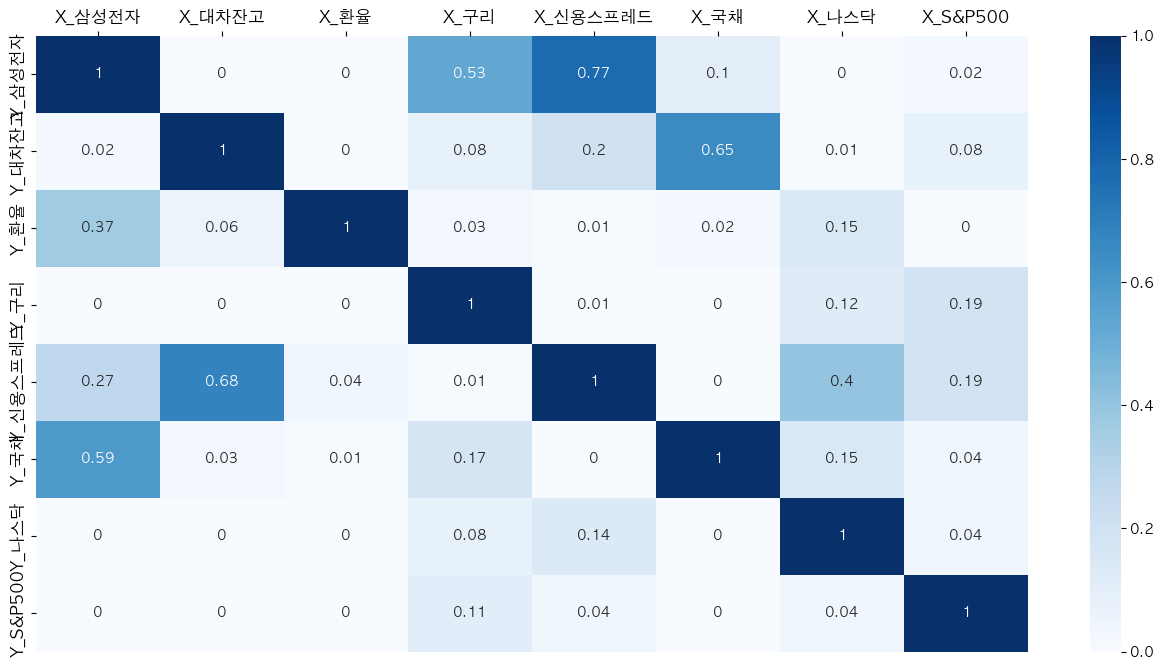

In [222]:
import seaborn as sns

plt.figure(figsize=(16,8))
ax = sns.heatmap(df_pairs, annot=True, cmap='Blues')
ax.xaxis.tick_top()
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

[구리 -> 대차잔고, 신용스프레드, 국채, 나스닥, s&p 500]
[구리, 대차잔고, 신용스프레드, 국채]

[신용 스프레드 -> 대차잔고, 구리, 국채, S&P 500]
[신용스프레드, 대차잔고, 구리, 국채]

[국채 -> 전종목]
[국채, 대차잔고, 신용스프레드, s&p 500]

[나스닥 ->대차잔고, s&p 500, 삼성전자]
[나스닥, 대차잔고, 국채, s&p 500, 삼성전자]

[S&P 500 ->대차잔고, 국채, 나스닥, 삼전]
[s&p 500, 대차잔고, 국채, 나스닥, 삼성전자]

[삼전 -> 구리, 나스닥, s&p 500]
[삼전 -> 나스닥, s&p 500]

In [297]:
# Cointegration Test

from statsmodels.tsa.vector_ar.vecm import coint_johansen

sample1 = ['환율', '국채', 'S&P500', '삼성전자']
sample2 = ['삼성전자', '나스닥', 'S&P500', '환율', '대차잔고']
sample3 = ['삼성전자', '국채', '대차잔고']
sample4 = ['S&P500', '환율', '국채', '삼성전자', '구리', '신용스프레드']
sample5 = ['신용스프레드', '국채', '나스닥', 'S&P500']
# sample1 = ['삼성전자', '대차잔고', 'S&P500', '나스닥']
# sample2 = ['삼성전자', '대차잔고', '나스닥']
# sample3 = ['환율', '구리', '신용스프레드', '국채', 'S&P500']
# sample4 = ['구리', '환율', '신용스프레드']
# sample5 = ['신용스프레드', '환율', '구리', '국채']
# sample6 = ['국채', '환율', 'S&P500', '신용스프레드']
# sample7 = ['나스닥', '삼성전자', 'S&P500', '대차잔고']
# sample8 = ['국채', '환율', 'S&P500', '나스닥', '삼성전자']


out1 = coint_johansen(df[sample1], 1, 1)
out2 = coint_johansen(df[sample2], 1, 1)
out3 = coint_johansen(df[sample3], 1, 1)
out4 = coint_johansen(df[sample4], 1, 1)
out5 = coint_johansen(df[sample5], 1, 1)

# 공적분 통계량
print(out1.lr1)
print(out2.lr1)
print(out3.lr1)
print(out4.lr1)


[5045.81658928 3515.54605982 2183.323212   1030.84499212]
[6020.33552869 4486.4412657  3067.43006879 1891.5099545   875.71190422]
[3163.85352925 2003.25455144  865.73385808]
[6924.48309262 5376.75443822 4011.47150542 2776.40274445 1693.74635216
  689.35724311]


In [298]:
cvt_df = pd.DataFrame(out1.cvt)
cvt_df.columns = ['90%', '95%', '99%']
cvt_df.index = sample1

cvt_df2 = pd.DataFrame(out2.cvt)
cvt_df2.columns = ['90%', '95%', '99%']
cvt_df2.index = sample2

cvt_df3 = pd.DataFrame(out3.cvt)
cvt_df3.columns = ['90%', '95%', '99%']
cvt_df3.index = sample3

cvt_df4 = pd.DataFrame(out4.cvt)
cvt_df4.columns = ['90%', '95%', '99%']
cvt_df4.index = sample4

print(cvt_df)
print(cvt_df2)
print(cvt_df3)
print(cvt_df4)


            90%      95%      99%
환율      51.6492  55.2459  62.5202
국채      32.0645  35.0116  41.0815
S&P500  16.1619  18.3985  23.1485
삼성전자     2.7055   3.8415   6.6349
            90%      95%      99%
삼성전자    75.1027  79.3422  87.7748
나스닥     51.6492  55.2459  62.5202
S&P500  32.0645  35.0116  41.0815
환율      16.1619  18.3985  23.1485
대차잔고     2.7055   3.8415   6.6349
          90%      95%      99%
삼성전자  32.0645  35.0116  41.0815
국채    16.1619  18.3985  23.1485
대차잔고   2.7055   3.8415   6.6349
             90%       95%       99%
S&P500  102.4674  107.3429  116.9829
환율       75.1027   79.3422   87.7748
국채       51.6492   55.2459   62.5202
삼성전자     32.0645   35.0116   41.0815
구리       16.1619   18.3985   23.1485
신용스프레드    2.7055    3.8415    6.6349


In [299]:
def calc_sig_dist(cols):
    out = coint_johansen(df[cols], 1, 1)
    stats = [round(x,2) for x in out.lr1]
    sigs = [round(x,2) for x in out.cvt[:, 1]]
    yns = [x>y for x,y in zip(stats,sigs)]
    dist = np.mean(np.array(stats) - np.array(sigs))
    

    print('stats: ',stats)
    print('sig-level: ',sigs)
    print('significant_yn: ',[x>y for x,y in zip(stats,sigs)])
    print('dist: ', round(dist,2))


In [300]:
calc_sig_dist(sample1)

stats:  [5045.82, 3515.55, 2183.32, 1030.84]
sig-level:  [55.25, 35.01, 18.4, 3.84]
significant_yn:  [True, True, True, True]
dist:  2915.76


In [301]:
calc_sig_dist(sample2)

stats:  [6020.34, 4486.44, 3067.43, 1891.51, 875.71]
sig-level:  [79.34, 55.25, 35.01, 18.4, 3.84]
significant_yn:  [True, True, True, True, True]
dist:  3229.92


In [302]:
calc_sig_dist(sample3)

stats:  [3163.85, 2003.25, 865.73]
sig-level:  [35.01, 18.4, 3.84]
significant_yn:  [True, True, True]
dist:  1991.86


In [303]:
calc_sig_dist(sample4)

stats:  [6924.48, 5376.75, 4011.47, 2776.4, 1693.75, 689.36]
sig-level:  [107.34, 79.34, 55.25, 35.01, 18.4, 3.84]
significant_yn:  [True, True, True, True, True, True]
dist:  3528.84


In [304]:
final_df = df[sample4]

In [305]:
final_df

,S&P500,환율,국채,삼성전자,구리,신용스프레드
Date,,,,,,
2009-01-07,-28.049988,-3.400024,0.110,397.855469,-0.0715,-0.070
2009-01-08,3.079956,29.400024,-0.190,-244.836426,-0.0315,-0.070
2009-01-09,-19.380004,21.299927,0.220,-229.530762,0.0825,-0.030
2009-01-12,-20.089966,0.500000,0.050,-53.558105,-0.0705,-0.050
2009-01-13,1.529968,-0.099975,-0.030,30.604004,0.0575,-0.010
...,...,...,...,...,...,...
2019-12-23,2.790039,-1.760010,-0.012,-450.332031,0.0060,0.004
2019-12-24,-0.630127,2.269897,-0.010,-450.347656,0.0215,0.009
2019-12-26,16.530029,-1.819946,-0.003,360.277344,0.0260,0.004


In [306]:
df_train = final_df.loc[:'2018-12-31']
df_test = final_df.loc['2019-01-01':]

In [307]:
# VAR 모델 생성
var = VAR(df_train)
var.select_order(maxlags=14).summary()


/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


,AIC,BIC,FPE,HQIC
0,1.296,1.311,3.656,1.302
1,0.6408,0.7401,1.898,0.6769
2,0.4979,0.6823,1.645,0.5649
3,0.3409,0.6105*,1.406,0.4389
4,0.2911,0.6458,1.338,0.4200
5,0.2373,0.6771,1.268,0.3971*
6,0.2304,0.7554,1.259,0.4212
7,0.2128*,0.8229,1.237*,0.4345
8,0.2151,0.9104,1.240,0.4678
9,0.2147,0.9951,1.240,0.4983


In [274]:
# 정규화
# 필요하면 aic >= 10일때 해야함!!!!
df_train_norm = (df_train / df_train.iloc[0]) - 1
df_train_norm


,국채,환율,S&P500,나스닥,삼성전자
Date,,,,,
2009-01-07,0.000000,0.000000,0.000000,0.000000,0.000000
2009-01-08,-2.727273,-9.647005,-1.109802,-1.336646,-1.615390
2009-01-09,1.000000,-7.264640,-0.309090,-0.148160,-1.576920
2009-01-12,-0.545455,-1.147058,-0.283780,-0.384847,-1.134617
2009-01-13,-1.272727,-0.970596,-1.054544,-1.143847,-0.923078
...,...,...,...,...,...
2018-12-21,-0.654545,1.382329,0.811046,2.665044,-1.000000
2018-12-24,-0.927273,-3.197035,1.335831,1.626978,-0.671108
2018-12-26,-1.354545,0.432341,-5.156859,-7.778700,-1.986559


In [275]:
# var = VAR(df_train_norm)
# var.select_order(maxlags=30).summary()

/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


,AIC,BIC,FPE,HQIC
0,-3.477,-3.465,0.03089,-3.473
1,-3.662,-3.590*,0.02569,-3.636*
2,-3.672*,-3.541,0.02542*,-3.625
3,-3.668,-3.477,0.02554,-3.598
4,-3.660,-3.410,0.02574,-3.569
5,-3.653,-3.344,0.02591,-3.541
6,-3.643,-3.274,0.02619,-3.509
7,-3.636,-3.208,0.02636,-3.480
8,-3.631,-3.144,0.02648,-3.454
9,-3.619,-3.072,0.02680,-3.421


In [308]:
model = var.fit(7)
model.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Wed, 10, Jan, 2024
Time:                     14:22:44
--------------------------------------------------------------------
No. of Equations:         6.00000    BIC:                   0.856946
Nobs:                     2462.00    HQIC:                  0.469397
Log likelihood:          -21008.1    FPE:                    1.28179
AIC:                     0.248233    Det(Omega_mle):         1.15531
--------------------------------------------------------------------
Results for equation S&P500
               coefficient       std. error           t-stat            prob
----------------------------------------------------------------------------
const             0.756580         0.340896            2.219           0.026
L1.S&P500        -0.045634         0.021512           -2.121           0.034
L1.환율            -0.027490         0.037087           -0.741           0.45

In [309]:
model.resid.corr()

,S&P500,환율,국채,삼성전자,구리,신용스프레드
S&P500,1.000000,-0.096694,0.056310,0.118866,0.307181,-0.020456
환율,-0.096694,1.000000,-0.044203,-0.036913,-0.081513,0.026228
국채,0.056310,-0.044203,1.000000,0.039139,0.068603,-0.452134
삼성전자,0.118866,-0.036913,0.039139,1.000000,0.106786,-0.008497
구리,0.307181,-0.081513,0.068603,0.106786,1.000000,-0.021474
신용스프레드,-0.020456,0.026228,-0.452134,-0.008497,-0.021474,1.000000


In [310]:
# 잔차의 독립성 검정
from statsmodels.stats.stattools import durbin_watson

durbin_res = pd.DataFrame([model.resid.columns, 
                           [round(x,2) for x in durbin_watson(model.resid)]]).T
durbin_res.set_index([0])


,1
0,
S&P500,2.0
환율,1.99
국채,2.01
삼성전자,2.0
구리,2.0
신용스프레드,1.99


In [311]:
model.k_ar

7

In [312]:
ins = df_train.values[-model.k_ar:]
ins

array([[-3.91999510e+01, -3.08007800e+00, -1.20000000e-02,
         1.74449219e+02,  5.05000000e-02,  1.00000000e-03],
       [-3.95400390e+01,  3.06005900e+00,  1.70000000e-02,
        -3.92511719e+02, -1.95000000e-02, -3.00000000e-03],
       [-5.07998050e+01, -8.09997600e+00,  3.80000000e-02,
         0.00000000e+00, -2.35000000e-02, -1.60000000e-02],
       [-6.55200190e+01,  7.46997100e+00,  8.00000000e-03,
         1.30851562e+02, -1.00000000e-02, -1.60000000e-02],
       [ 1.16599853e+02, -4.86999500e+00, -3.90000000e-02,
        -3.92507812e+02,  4.00000000e-02,  2.00000000e-03],
       [ 2.11301270e+01,  8.90015000e-01,  3.00000000e-03,
         2.23605469e+02, -4.10000000e-02,  6.00000000e-03],
       [-3.09008800e+00, -3.92004400e+00,  7.00000000e-03,
         3.96148438e+02,  1.15000000e-02, -4.00000000e-03]])

In [351]:
ins = df_train_norm.values[-model.k_ar:]
ins

array([[  0.97103986,   0.14116955,  -2.1       ,  -0.4818198 ,
         -0.97983871,  -0.98181818],
       [ -1.07310745,   0.10882096,  -0.2       ,  -2.16592285,
         -1.0483871 ,  -1.00909091],
       [ -7.97794317,  -1.93235903,   0.4       ,  -3.72041702,
         -1.01612903,  -1.06363636],
       [ -8.44965655,  -2.36175587,  -2.4       ,  -0.48184301,
         -1.06048387,  -0.95454545],
       [ -0.96965917,   0.0294042 ,  -1.        ,  -1.64770784,
         -1.66129032,  -0.91818182],
       [ -6.40688979,  -0.09410137,   0.2       ,  -0.48183141,
         -0.59274194,  -1.00909091],
       [ -6.45379848,  -1.90001074,  -2.7       ,  -2.16587643,
         -1.15725806,  -0.97272727],
       [ -8.00686966,   1.38232837,  -4.8       ,  -1.        ,
         -1.18951613,  -0.85454545],
       [-10.037244  ,  -3.19703414,  -1.8       ,  -0.61138226,
         -1.08064516,  -0.85454545],
       [ -1.        ,   0.255879  ,  -1.        ,  -1.        ,
         -1.        ,  -0.9

In [313]:
f = model.forecast(y=ins, steps=len(df_test))
df_f = pd.DataFrame(f, columns=df_train.columns)
df_f


,S&P500,환율,국채,삼성전자,구리,신용스프레드
0,7.732135,-4.251660,-0.008576,106.715697,0.005136,-0.003207
1,3.640093,0.505441,-0.001454,65.738885,0.012885,0.004947
2,-3.876599,1.535822,-0.005352,-50.078033,0.009713,0.000252
3,-2.207564,0.465627,0.002968,-64.426885,0.003653,-0.007547
4,-0.055196,-0.389536,0.006606,0.156489,-0.015489,-0.005150
...,...,...,...,...,...,...
241,0.669540,-0.106261,-0.000695,10.856668,0.000512,-0.001570
242,0.669540,-0.106261,-0.000695,10.856668,0.000512,-0.001570
243,0.669540,-0.106261,-0.000695,10.856668,0.000512,-0.001570
244,0.669540,-0.106261,-0.000695,10.856668,0.000512,-0.001570


In [294]:
# # 역정규화
# df_f_denorm = (df_f + 1).mul(df_train.iloc[0].to_numpy())
# df_f_denorm

,국채,환율,S&P500,나스닥,삼성전자
0,-0.459027,-265.906634,68.238907,553.209960,-7128.556023
1,0.513208,-14.562824,106.294771,738.788449,-6598.360710
2,-0.006823,28.332230,1.317686,-31.797576,1580.458820
3,-0.037461,2.093191,-24.628308,-87.424963,312.538897
4,-0.000789,-1.011859,3.426696,14.477842,-230.409677
...,...,...,...,...,...
241,-0.000588,-0.082969,0.638114,2.012512,10.612241
242,-0.000588,-0.082969,0.638114,2.012512,10.612241
243,-0.000588,-0.082969,0.638114,2.012512,10.612241
244,-0.000588,-0.082969,0.638114,2.012512,10.612241


In [314]:
x = var_df[sample4][:'2019-01-01'].dropna()
x

,S&P500,환율,국채,삼성전자,구리,신용스프레드
Date,,,,,,
2009-01-02,931.799988,1322.500000,3.420,7192.032227,1.4440,8.620
2009-01-05,927.450012,1307.800049,3.350,7283.844727,1.4420,8.520
2009-01-06,934.700012,1304.400024,3.340,7620.496582,1.5660,8.510
2009-01-07,906.650024,1301.000000,3.450,8018.352051,1.4945,8.450
2009-01-08,909.729980,1330.400024,3.260,7773.515625,1.4630,8.440
...,...,...,...,...,...,...
2018-12-21,2416.620117,1120.030029,1.838,33711.414062,2.6785,6.543
2018-12-24,2351.100098,1127.500000,1.846,33842.265625,2.6685,6.538
2018-12-26,2467.699951,1122.630005,1.807,33449.757812,2.7085,6.545


In [315]:
for i in df_train:
    df_f[i] = np.r_[x[i].iloc[-1],
                            df_f[i]].cumsum()[1:]

In [316]:
df_f.index = df_test.index[:len(df_test)]

In [319]:
df_f

,S&P500,환율,국채,삼성전자,구리,신용스프레드
Date,,,,,,
2019-01-02,2493.472125,1115.348316,1.808424,34176.227416,2.684136,6.537793
2019-01-03,2497.112218,1115.853757,1.806970,34241.966301,2.697021,6.542740
2019-01-04,2493.235619,1117.389579,1.801618,34191.888267,2.706734,6.542992
2019-01-07,2491.028055,1117.855206,1.804586,34127.461382,2.710387,6.535446
2019-01-08,2490.972859,1117.465670,1.811191,34127.617871,2.694898,6.530295
...,...,...,...,...,...,...
2019-12-23,2649.619150,1092.906313,1.644761,36696.441964,2.816177,6.157647
2019-12-24,2650.288690,1092.800052,1.644066,36707.298632,2.816689,6.156077
2019-12-26,2650.958230,1092.693790,1.643371,36718.155300,2.817201,6.154507


In [317]:
x = var_df[sample4].dropna()
df_test = x['2019-01-01':]

In [290]:
df_test

,삼성전자,대차잔고,나스닥
Date,,,
2019-01-02,34113.542969,6.122600e+13,6665.939941
2019-01-03,33101.132812,6.018500e+13,6463.500000
2019-01-04,32969.085938,6.222900e+13,6738.859863
2019-01-07,34113.542969,6.327200e+13,6823.470215
2019-01-08,33541.308594,6.320000e+13,6897.000000
...,...,...,...
2019-12-23,49987.886719,6.496400e+13,8945.650391
2019-12-24,49537.539062,6.243100e+13,8952.879883
2019-12-26,49897.816406,6.201000e+13,9022.389648


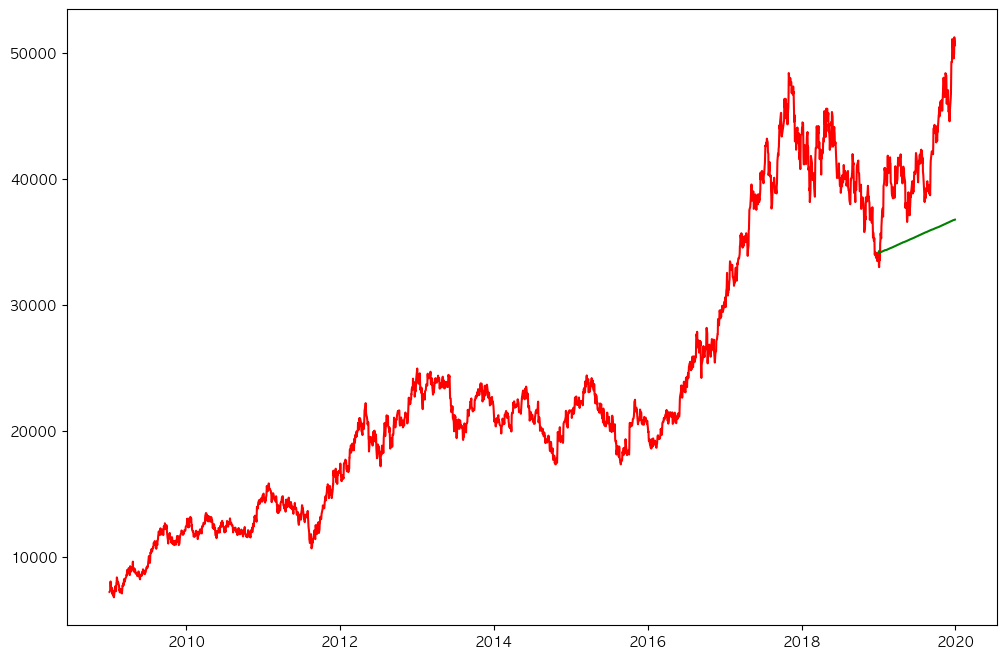

In [320]:
plt.figure(figsize=(12, 8))
plt.plot(var_df['삼성전자'], c='r')
plt.plot(df_f['삼성전자'], c='g')

Date
2019-01-02   -5.799927
2019-01-03    8.380005
2019-01-04    1.939941
2019-01-07   -9.719971
2019-01-08    2.000000
                ...   
2019-10-18   -7.559936
2019-10-21    0.809936
2019-10-22   -6.679932
2019-10-23   -0.140014
2019-10-24   -1.560059
Name: 환율, Length: 200, dtype: float64
Date
2019-01-02    1115.348316
2019-01-03    1115.853757
2019-01-04    1117.389579
2019-01-07    1117.855206
2019-01-08    1117.465670
                 ...     
2019-10-18    1097.794330
2019-10-21    1097.688069
2019-10-22    1097.581807
2019-10-23    1097.475546
2019-10-24    1097.369285
Name: 환율, Length: 200, dtype: float64
Date
2019-01-02   -0.0540
2019-01-03   -0.0545
2019-01-04    0.0810
2019-01-07   -0.0105
2019-01-08    0.0195
               ...  
2019-10-18    0.0380
2019-10-21    0.0100
2019-10-22   -0.0130
2019-10-23    0.0405
2019-10-24   -0.0035
Name: 구리, Length: 200, dtype: float64
Date
2019-01-02    2.684136
2019-01-03    2.697021
2019-01-04    2.706734
2019-01-07    2.710387
2019

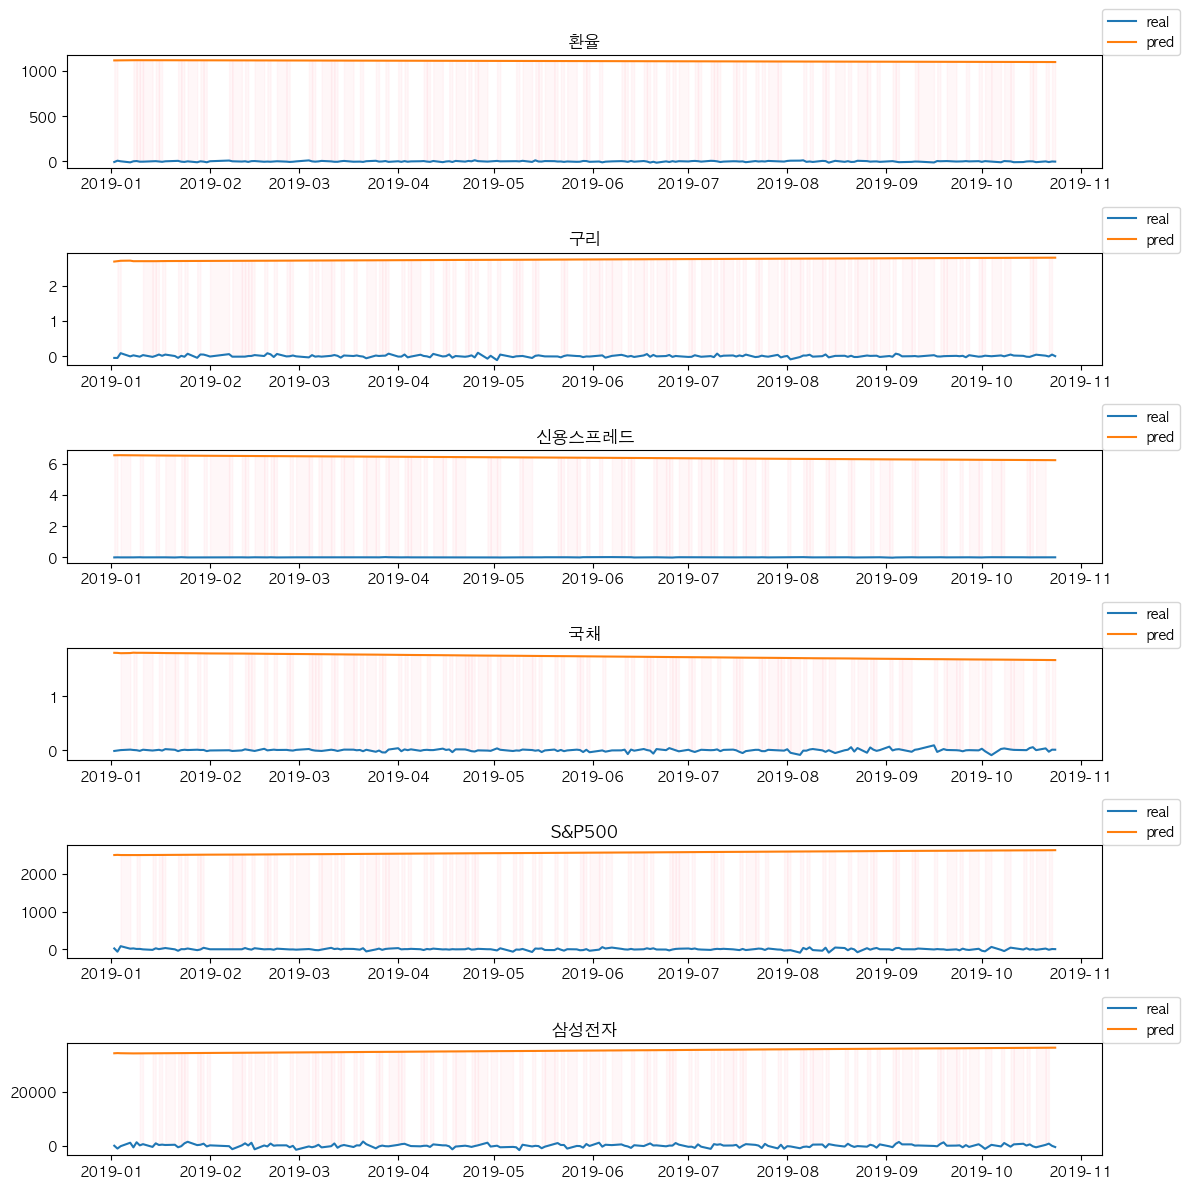

In [158]:
fig, axes = plt.subplots(nrows=6, ncols=1, figsize=(12, 12))

draw_subplot(axes, 0, '환율')
draw_subplot(axes, 1, '구리')
draw_subplot(axes, 2, '신용스프레드')
draw_subplot(axes, 3, '국채')
draw_subplot(axes, 4, 'S&P500')
draw_subplot(axes, 5, '삼성전자')

plt.tight_layout()
plt.show()


In [2]:
!pip install xgboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 23.5 MB/s eta 0:00:00a 0:00:01

[notice] A new release of pip is available: 23.3.1 -> 23.3.2
[notice] To update, run: python3.11 -m pip install --upgrade pip


In [39]:
# 번외 : 회귀
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

var_df.dropna(inplace=True)
df_train = var_df.loc[:'2018-12-31']
df_test = var_df.loc['2019-01-01':]

y_train = df_train['삼성전자']
X_train = df_train.drop('삼성전자', axis=1)
model = XGBRegressor()
model.fit(X_train, y_train)

y_pred = model.predict(df_test.drop('삼성전자', axis=1))
mae = mean_absolute_error(df_test['삼성전자'],y_pred )
mse = mean_squared_error(df_test['삼성전자'], y_pred)
rmse = np.sqrt(mse)

print(f'mae:{mae}, rmse:{rmse}')

mae:3045.8537289915967, rmse:4328.850380164201


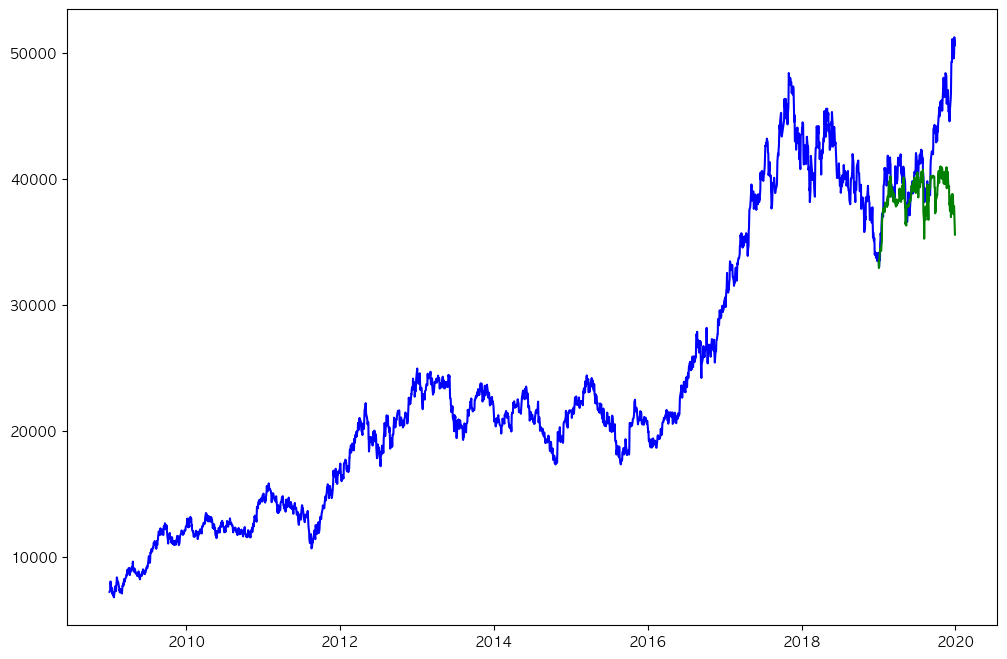

In [30]:
# 그래프 그리기

y_pred = pd.DataFrame(y_pred, index=df_test.index)

plt.figure(figsize=(12, 8))
plt.plot(var_df['삼성전자'], c='b')
plt.plot(y_pred, c='g')

In [31]:
X_train.isna().sum()

대차잔고      0
환율        0
구리        0
신용스프레드    0
국채        0
나스닥       0
S&P500    0
dtype: int64

In [40]:
# feature selection
from sklearn.linear_model import Lasso

model = Lasso(alpha=100)
model.fit(X_train, y_train)

feature_importance = model.coef_
print(feature_importance)

[3.95750198e-10 2.07765920e+01 2.91269132e+03 6.87103261e+01
 3.20420741e+03 1.94657868e+00 4.04917545e+00]


/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.263e+10, tolerance: 2.363e+07
  model = cd_fast.enet_coordinate_descent(


In [36]:
df_train = var_df.loc[:'2018-12-31']
df_test = var_df.loc['2019-01-01':]

y_train = df_train['삼성전자']
X_train = df_train.drop(['삼성전자', '구리', '신용스프레드', '국채'], axis=1)
model = XGBRegressor()
model.fit(X_train, y_train)

y_pred = model.predict(df_test.drop(['삼성전자', '구리', '신용스프레드', '국채'], axis=1))
mae = mean_absolute_error(df_test['삼성전자'],y_pred )
mse = mean_squared_error(df_test['삼성전자'], y_pred)
rmse = np.sqrt(mse)

print(f'mae:{mae}, rmse:{rmse}')

mae:2825.289111738445, rmse:4001.9807665776766


In [162]:
# 그래프 그리기
y_pred = pd.DataFrame(y_pred, index=df_test.index)

plt.figure(figsize=(12, 8))
plt.plot(var_df['삼성전자'], c='b')
plt.plot(y_pred, c='g')

ValueError: Shape of passed values is (238, 1), indices imply (246, 1)

In [46]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(df_train.drop('삼성전자', axis=1))
x_test_scaled = scaler.fit_transform(df_test.drop('삼성전자', axis=1))

model = XGBRegressor()
model.fit(x_train_scaled, df_train['삼성전자'])
pred = model.predict(x_test_scaled)

mae = mean_absolute_error(df_test['삼성전자'],pred )
mse = mean_squared_error(df_test['삼성전자'], pred)
rmse = np.sqrt(mse)

print(f'mae:{mae}, rmse:{rmse}')


mae:19564.79180754333, rmse:20890.572388850054
